In [1]:
%config InlineBackend.rc = {"figure.dpi": 72, "figure.figsize": (6.0, 4.0)}
%matplotlib inline

import abtem
import ase
import matplotlib.pyplot as plt
import numpy as np
from ase.build import bulk

(examples:cbed_quickstart)=
# CBED quickstart

This notebook demonstrates a basic CBED simulation of silicon in the $atoms111>$ zone axis.

## Configuration

We start by setting our configuration.

In [64]:
abtem.config.set({"device": "cpu"})
abtem.config.set({"fft": "mkl"})

## Create atomic model
In this section we create the atomic model, you can modify this simulation by swapping in your own atomic model. See our [walkthough](walkthough:atomic_models) or our [tutorial]() on atomic models. 

We create an atomic model of silicon using the `bulk` function from ASE.

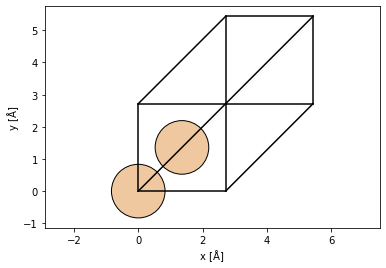

In [65]:
silicon = bulk("Si", crystalstructure="diamond")

abtem.show_atoms(silicon, plane="xy");

We can choose the $<111>$ zone axis to be a propagation direction using the `surface` function. 

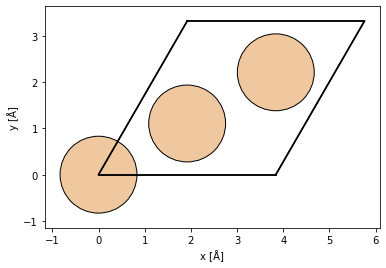

In [4]:
silicon_111 = ase.build.surface(silicon, (1, 1, 1), layers=3, periodic=True)

abtem.show_atoms(silicon_111, plane="xy");

The `surface` function may produce a non-orthogonal cell, which is incompatiable with *abTEM*. We can create an equivalent orthgonal cell using `abtem.orthogonalize_cell`. This mas some limitations, see this tutorial.

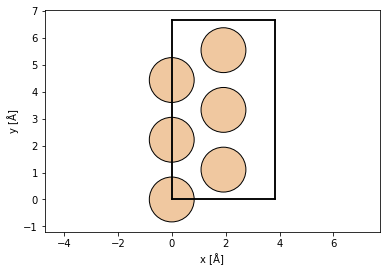

In [17]:
silicon_111_orthogonal = abtem.orthogonalize_cell(silicon_111)

abtem.show_atoms(silicon_111_orthogonal);

Finally we repeat the structure in $x$ and $y$, this will improve the reciprocal space resolution. We aso repeat the structure in $z$, thus simulating a thicker sample.

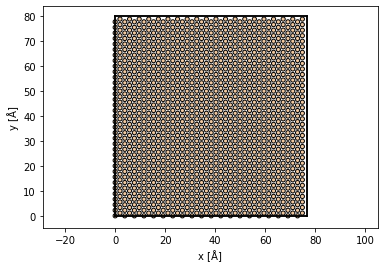

In [41]:
atoms = silicon_111_orthogonal * (20, 12, 80)

abtem.show_atoms(atoms);

## Potential

We create an ensemble of potentials using the frozen phonon. See our [walkthrough](walkthrough:frozen_phonons) on frozen phonons. 

In [42]:
frozen_phonons = abtem.FrozenPhonons(atoms, 8, {"Si": 0.078})

We create a [potential]() from the atomic model, see our introduction to potentials. 

In [43]:
potential = abtem.Potential(
    frozen_phonons,
    gpts=512,
    projection="infinite",
    slice_thickness=2,
    exit_planes=20,
)

In [44]:
potential.sampling

(0.14998397741574035, 0.1558679215231952)

## Wave function

We create a probe wave function at an energy of 100 keV with a convergence semiangle of $9.4 \ \mathrm{mrad}$. See our [walkthrough](walkthough:wave_functions) on wave functions. 

Partial coherence is typically not important in CBED simulations, hence, we neglect it here.

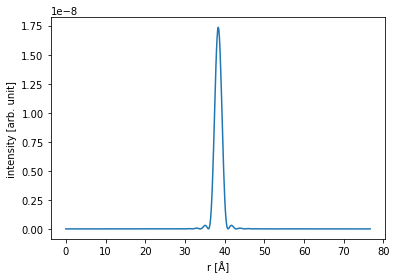

In [49]:
wave = abtem.Probe(energy=100e3, semiangle_cutoff=9.4, taper=0.5)
wave.grid.match(potential)
wave.profile().show();

## Multislice

In [46]:
measurement = wave.multislice(potential).diffraction_patterns(max_angle=30)

In [47]:
measurement = measurement.mean(0)

measurement.array

dask.array<mean_agg-aggregate, shape=(20, 127, 131), dtype=float32, chunksize=(20, 127, 131), chunktype=numpy.ndarray>

Execute the multislice algorithm.

In [48]:
measurement.compute()

[########################################] | 100% Completed |  1min  8.6s


## Postprocess

## Visualize results

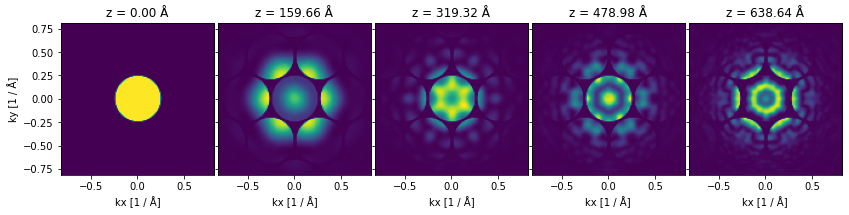

In [50]:
fig, ax = measurement[::4].show(
    explode=True,
    figsize=(14, 4),
    image_grid_kwargs={"axes_pad": 0.05},
)

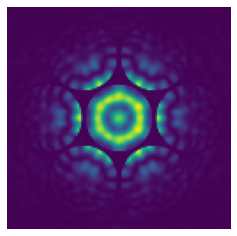

In [63]:
fig, ax = measurement[-3].show()
ax.axis("off")
plt.savefig("../thumbnails/cbed_quickstart.png", bbox_inches="tight", pad_inches=0)